# Analysing the bank's customer churn 
**Task:**  
Analyse the customers of a regional bank and identify the customer segments who tend to quit the bank:
- exploratory analysis,  
- customer segmentation
- hypothesis formulation and testing.  
  
1. Data Examination, 
2. Data Pre-processing,
2. Exploratory Data Analysis (distributions of probability of customers leaving by attributes):
    + analysing customer activity (payment amounts, age of purchases, number of products used),
    + analysis of customer churn by attributes (gender, age, etc.),
    + segmentation by combined attributes (based on probability distributions of leaving)
3. Statistical Analysis:
    + hypothesis generation and testing,
4. Summary.

In [1]:
# libraries import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys

# phik install if heeded
#!"{sys.executable}" -m pip install phik

import phik
from phik.report import plot_correlation_matrix
from phik import report
from scipy import stats as st
#from sklearn.metrics import plot_confusion_matrix

In [2]:
# hiding warnings
import warnings
warnings.filterwarnings("ignore")

# widening the notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# TOC setting
display(HTML("<style>#toc-wrapper{ position: relative; width: 20%; top: 130px; left: 0px; }</style>"))

# plot size setting
plt.rcParams["figure.figsize"] = (15,10)

## Open the data file and examine the general information

In [3]:
bank = pd.read_csv('https://code.s3.yandex.net/datasets/bank_scrooge.csv')

In [4]:
bank

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,120553,814.0,Рыбинск,М,27.0,1,78144.65,1,0,1,18943.64,0
9996,139170,894.0,Ярославль,М,46.0,0,NaN,1,1,0,196898.29,0
9997,115639,903.0,Ярославль,М,24.0,0,NaN,2,1,1,108905.09,0
9998,148700,777.0,Ярославль,Ж,68.0,3,865457.97,3,0,1,86874.90,0


**Columns:**  
USERID - user identifier,  
score - credit scoring points,  
city,  
gender,  
age,  
equity - ownership score,  
balance - last minute account balance,  
products - number of products used by the client,  
credit_card - credit card existence,  
last_activity - activity of the client,  
EST_SALARY - estimated income of the client,  
churn - sign of churn.

In [5]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


In [6]:
bank.isnull().sum()

USERID              0
score               0
city                0
gender              0
age                26
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
EST_SALARY          0
churn               0
dtype: int64

There are a few blanks in the client's balance data and quite a few blanks in the age column. It will be adequate to leave the existing blanks, as it is impossible to replace neither age nor balance, it can be absolutely any values.

In [7]:
bank.describe().style.format({'balance': '{:.2f}'})

,USERID,score,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
count,10000.000000,10000.000000,9974.000000,10000.000000,7705.00,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,171814.712600,848.699400,42.734409,2.627600,827794.31,1.870100,0.680400,0.523500,147866.885544,0.182000
std,33708.238120,65.448519,12.179971,1.980836,1980614.15,0.792647,0.466345,0.499472,139388.510832,0.385864
min,94561.000000,642.000000,18.000000,0.000000,0.00,0.000000,0.000000,0.000000,2546.300000,0.000000
25%,142810.250000,802.000000,33.000000,0.000000,295554.16,1.000000,0.000000,0.000000,75251.900000,0.000000
50%,172728.000000,853.000000,40.000000,3.000000,524272.20,2.000000,1.000000,1.000000,119658.105000,0.000000
75%,201261.750000,900.000000,51.000000,4.000000,980705.85,2.000000,1.000000,1.000000,174500.542500,0.000000
max,229145.000000,1000.000000,86.000000,9.000000,119113552.01,5.000000,1.000000,1.000000,1395064.450000,1.000000


The numerical data looks good.  
At first, huge numbers in the balance and salary may actually exist, a salary of a few thousand may also be, because the client may have a dark salary, or it may be a pension, subsidies, allowances, whatever. 
It is also necessary to study 0 in clients' balances and products (because if a person is a client, he uses something).

In [8]:
bank.dtypes

USERID             int64
score            float64
city              object
gender            object
age              float64
equity             int64
balance          float64
products           int64
credit_card        int64
last_activity      int64
EST_SALARY       float64
churn              int64
dtype: object

The data types match the information in the columns. We could replace age and score with integer values, but then there will be zeros, because there are blanks in these columns. Let's leave them as they are.

## Data pre-processing

In [9]:
# Let's bring the column names to the lower snake case
bank.columns = (bank.columns
                .str.lower()
             )
bank = bank.rename(columns={"userid": "user_id"})

In [10]:
# checking duplicates
bank.duplicated().sum()

0

In [11]:
bank_user_dups = bank[bank.duplicated('user_id', keep=False) == True]
print('Duplicated user_id: ' + str(bank_user_dups['user_id'].nunique()) + ' out of ' + str(bank_user_dups['user_id'].count()) + ' lines')
bank_user_dups.sort_values(by='user_id').head(10)

Duplicated user_id: 73 out of 146 lines


,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1893,116540,883.0,Рыбинск,Ж,55.0,1,362756.49,3,0,1,175920.48,1
7694,116540,887.0,Ярославль,Ж,38.0,0,NaN,1,0,1,119247.61,0
7542,117943,880.0,Ярославль,Ж,40.0,0,NaN,1,1,0,137718.93,0
4866,117943,855.0,Рыбинск,Ж,32.0,6,1036832.93,4,1,1,107792.71,1
5896,120258,905.0,Ярославль,М,30.0,0,NaN,1,1,1,146427.96,0
5863,120258,908.0,Рыбинск,Ж,38.0,4,2213581.63,2,0,1,160327.77,1
1411,123461,829.0,Ярославль,Ж,59.0,0,96222.44,2,0,1,102771.55,1
8638,123461,934.0,Рыбинск,М,34.0,0,NaN,2,1,0,291619.27,0
8164,124450,859.0,Ярославль,Ж,38.0,6,516811.20,1,1,1,95144.63,1
9775,124450,758.0,Рыбинск,Ж,36.0,0,73574.07,2,0,1,79963.59,0


In [12]:
bank_user_dups.sort_values(by='user_id').query('churn == 1').count()

user_id          50
score            50
city             50
gender           50
age              50
equity           50
balance          50
products         50
credit_card      50
last_activity    50
est_salary       50
churn            50
dtype: int64

We see that 73 user_id are duplicated. 
Most of the duplicates are due to the user leaving and linking the old id to the new client, however, not everywhere.  
It seems that some of the duplicate user_ids were assigned by mistake (e.g. technical). Two records with the same user_id can have different gender, age and other values. You can't delete such duplicates.
  
I think it is better to create a new numeration and use it for analysis, because all users are important:

In [13]:
bank['index_id'] = bank.index
bank[bank.duplicated('user_id', keep=False) == True].sort_values(by='user_id')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,index_id
1893,116540,883.0,Рыбинск,Ж,55.0,1,362756.49,3,0,1,175920.48,1,1893
7694,116540,887.0,Ярославль,Ж,38.0,0,NaN,1,0,1,119247.61,0,7694
7542,117943,880.0,Ярославль,Ж,40.0,0,NaN,1,1,0,137718.93,0,7542
4866,117943,855.0,Рыбинск,Ж,32.0,6,1036832.93,4,1,1,107792.71,1,4866
5896,120258,905.0,Ярославль,М,30.0,0,NaN,1,1,1,146427.96,0,5896
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2597,226719,990.0,Ярославль,М,37.0,4,14648692.14,2,0,0,934412.61,1,2597
8205,227795,840.0,Рыбинск,М,34.0,2,350768.03,1,1,0,102036.14,1,8205
8497,227795,839.0,Ярославль,М,34.0,2,326593.14,2,1,0,103314.92,0,8497
6457,228075,839.0,Рыбинск,М,39.0,5,507199.85,3,0,1,85195.80,0,6457


In [14]:
# making the new column first
cols = bank.columns.tolist()
cols = cols[-1:] + cols[:-1]
cols

['index_id',
 'user_id',
 'score',
 'city',
 'gender',
 'age',
 'equity',
 'balance',
 'products',
 'credit_card',
 'last_activity',
 'est_salary',
 'churn']

In [15]:
bank = bank[cols]
bank.head()

,index_id,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [16]:
# checking errors/typos in city names
bank['city'].unique()

array(['Рыбинск', 'Ярославль', 'Ростов'], dtype=object)

In [17]:
# checking for errors in the gender column
bank['gender'].unique()

array(['Ж', 'М'], dtype=object)

In [18]:
# checking zero balances
bank.query('balance == 0')

,index_id,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
3900,3900,179831,730.0,Ярославль,М,18.0,0,0.0,2,1,1,64548.33,0
6757,6757,148456,813.0,Ярославль,М,20.0,2,0.0,2,1,0,23876.51,0


In [19]:
# checking null balances
print(bank['balance'].isnull().sum())
display(bank.query('balance.isnull()').head().sort_values(by='index_id'))

2295


,index_id,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
2,2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
9,9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0
10,10,148929,927.0,Ростов,М,52.0,0,NaN,1,1,1,196820.07,0
11,11,172184,921.0,Ростов,М,41.0,0,NaN,1,1,1,217469.48,0
19,19,127034,922.0,Рыбинск,Ж,53.0,0,NaN,1,0,0,147094.82,0


Unavailable balance with a valid client is odd, let's find out more information about these cells:

In [20]:
bank.query('balance.isnull()').describe().style.format({'est_salsry': '{:.2f}'})

,index_id,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,2295.000000,2295.000000,2295.000000,2279.000000,2295.000000,0.000000,2295.000000,2295.000000,2295.000000,2295.000000,2295.000000
mean,4981.598693,172069.447930,865.352070,42.093023,0.050980,nan,1.162092,0.815686,0.549455,226310.208654,0.005664
std,2881.329159,33337.084589,89.603091,11.941551,0.225872,nan,0.402532,0.387824,0.497657,199771.793737,0.075066
min,2.000000,114182.000000,642.000000,18.000000,0.000000,nan,0.000000,0.000000,0.000000,20274.030000,0.000000
25%,2503.000000,143095.500000,871.000000,33.000000,0.000000,nan,1.000000,1.000000,0.000000,120347.700000,0.000000
50%,4900.000000,172659.000000,903.000000,40.000000,0.000000,nan,1.000000,1.000000,1.000000,174160.680000,0.000000
75%,7464.500000,201551.000000,922.000000,49.000000,0.000000,nan,1.000000,1.000000,1.000000,240014.995000,0.000000
max,9997.000000,229145.000000,990.000000,86.000000,3.000000,nan,3.000000,1.000000,1.000000,1333687.360000,1.000000


Such indicators as `equity` (number of ownership points), `products` (number of products used by the client) are lower for clients with nan balance. They use `credit cards` more often on average, and their `est_salary` (client's estimated income) is higher.
Client's leaving is not related to balance blanks.  
There is no reason to drop such records.

In [21]:
# checking clients with 0 products
bank.query('products == 0')

,index_id,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
8957,8957,147837,962.0,Рыбинск,Ж,79.0,3,NaN,0,0,0,25063.96,1


We see that the customer with 0 products is old enough and has left the bank, it would be reasonable to remove him. 

In [22]:
bank = bank.drop(index=8957)

In [23]:
# check
bank.query('products == 0')

,index_id,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn


In [24]:
# checking clients with a rather small salary
bank.query('est_salary < 7000')

,index_id,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1753,1753,161271,836.0,Ярославль,Ж,19.0,4,7703.05,4,1,1,5043.14,0
2186,2186,201407,938.0,Рыбинск,Ж,69.0,1,325483.52,3,0,1,3487.33,0
4860,4860,193417,823.0,Ростов,Ж,64.0,2,277249.69,2,0,0,5341.50,0
8783,8783,114221,948.0,Ярославль,Ж,26.0,1,77092.89,1,1,0,2546.30,0


Well, it is interesting, by age half of users with income less than 7000 rubles are not retirees, women of retirement age have a decent amount on the balance, but the question with income is unanswered. The income of the younger ones in theory can be an increased scholarship or a part-time job.  
I don't see the point in removing them, they use different products, younger ones have a credit card, older ones have several products.

## Exploratory Data Analysis

Let's start with general churn:

In [25]:
# picking off the clients who've left
churn = bank.query('churn == 1')
display(churn.head())

churn_cnt = churn['index_id'].count()

user_cnt = bank['churn'].count()

print('Clients left: ' + str(churn_cnt) + ' out of ' + str(user_cnt) + '.')
print('Churn share: ' + str(round(churn_cnt / user_cnt * 100, 1)) + '%.')

,index_id,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
3,3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1
12,12,132970,845.0,Ярославль,Ж,31.0,3,591928.52,2,1,1,112697.16,1
40,40,129705,811.0,Рыбинск,М,34.0,2,129799.35,1,0,0,96242.71,1


Clients left: 1819 out of 9999.
Churn share: 18.2%.


Let's look at the distribution of probability density to determine the churn values of the remaining quantitative characteristics:

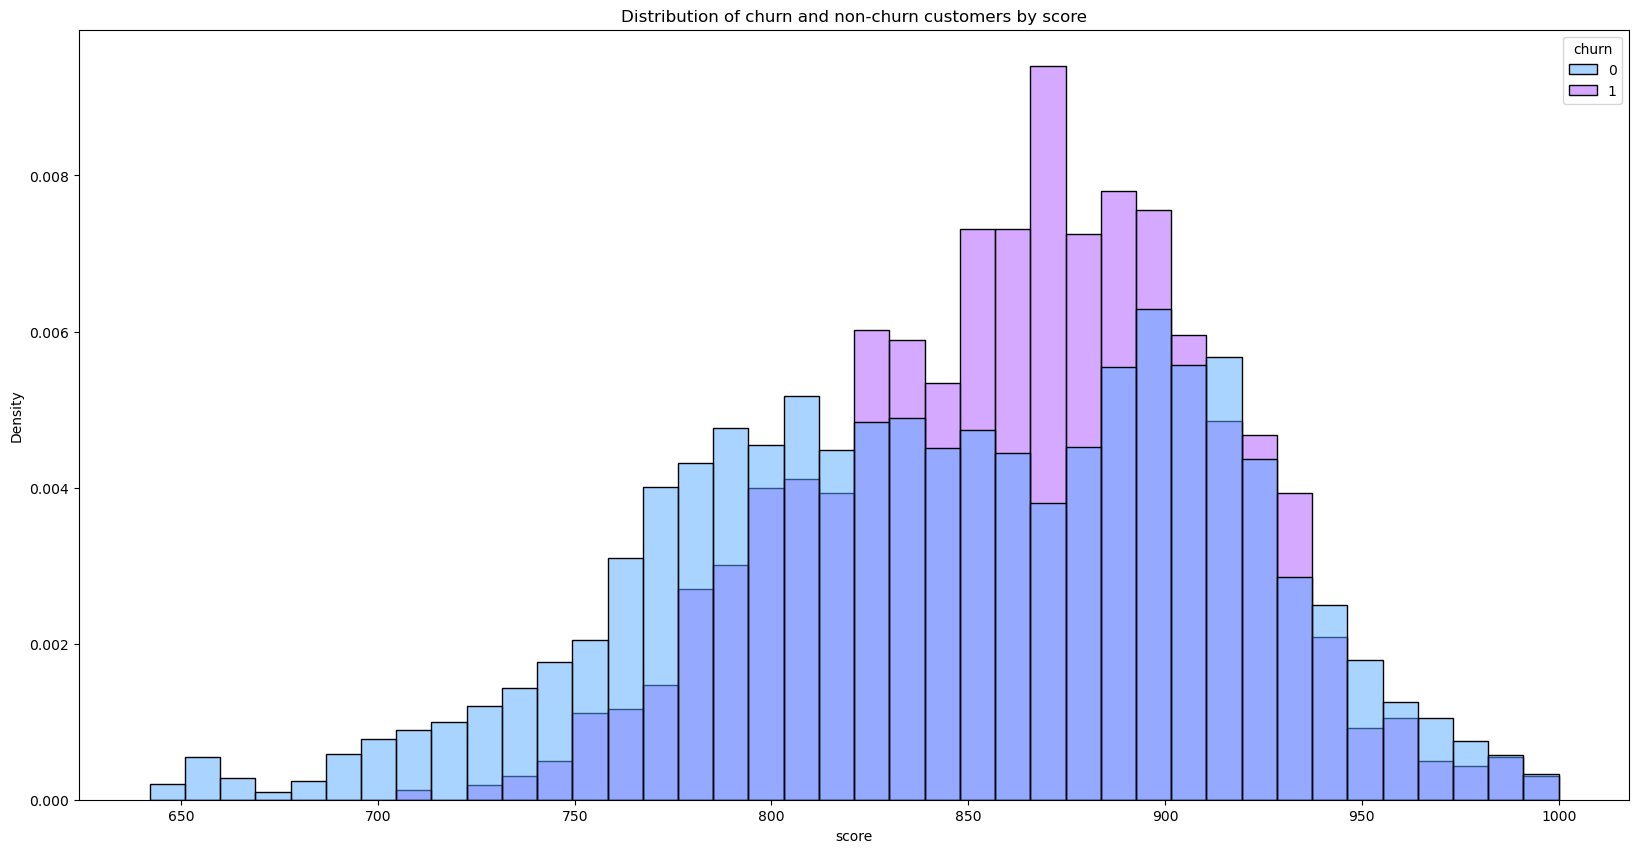

In [26]:
plt.figure(figsize=(20, 10))
ax=sns.histplot(data=bank, x='score', hue='churn', stat='density', common_norm=False, palette='cool')
plt.title(f'Distribution of churn and non-churn customers by score')
plt.show()

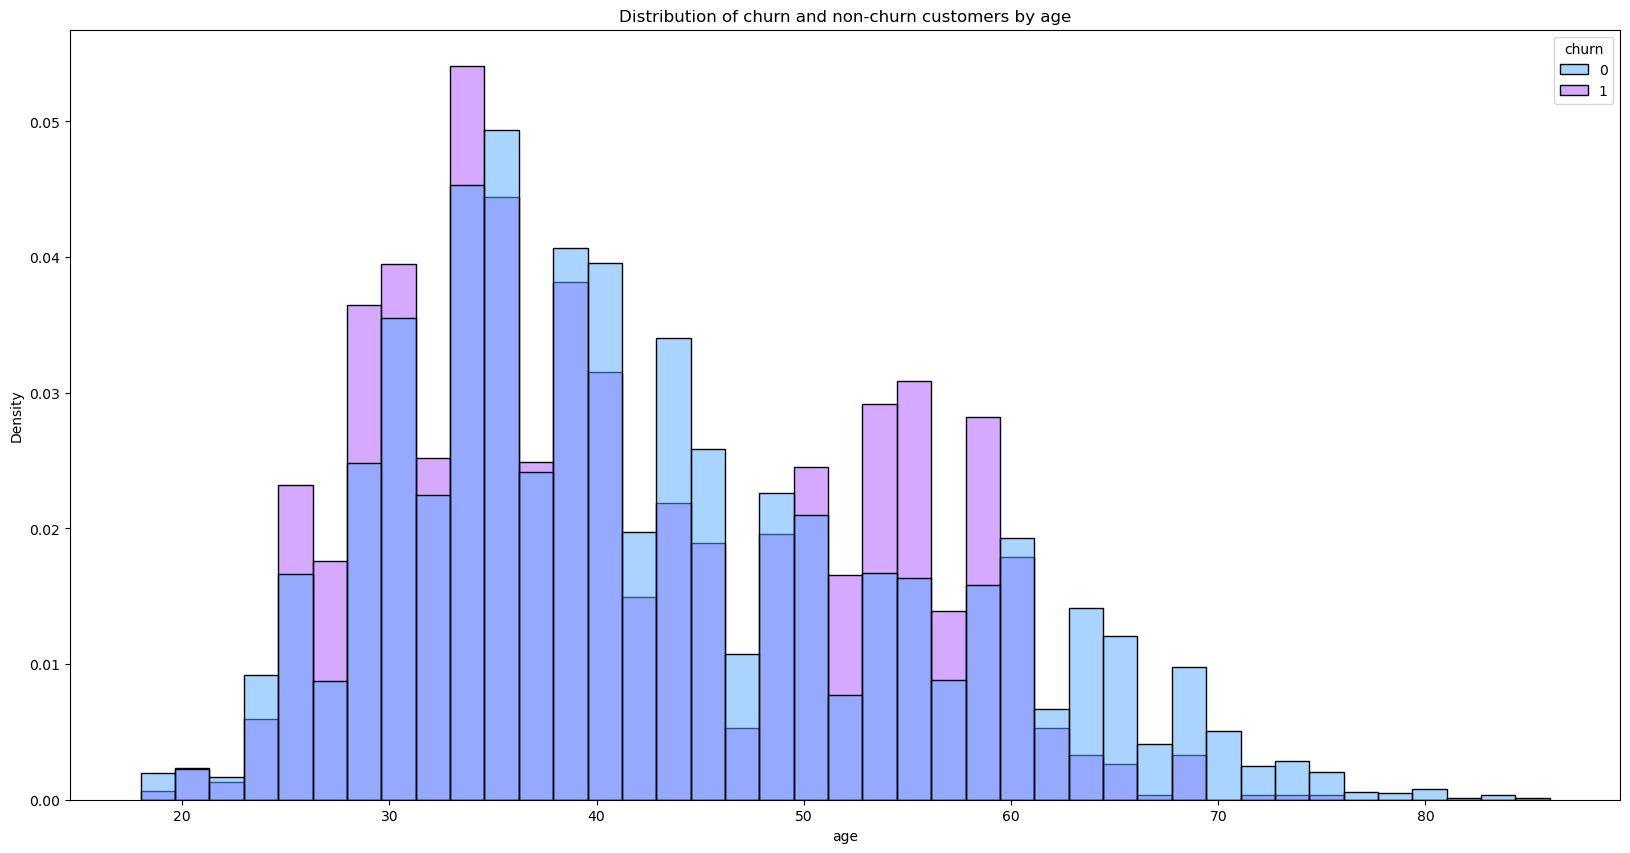

In [27]:
plt.figure(figsize=(20, 10))
ax=sns.histplot(data=bank, x='age', hue='churn', stat='density', common_norm=False, palette='cool')
plt.title(f'Distribution of churn and non-churn customers by age')
plt.show()

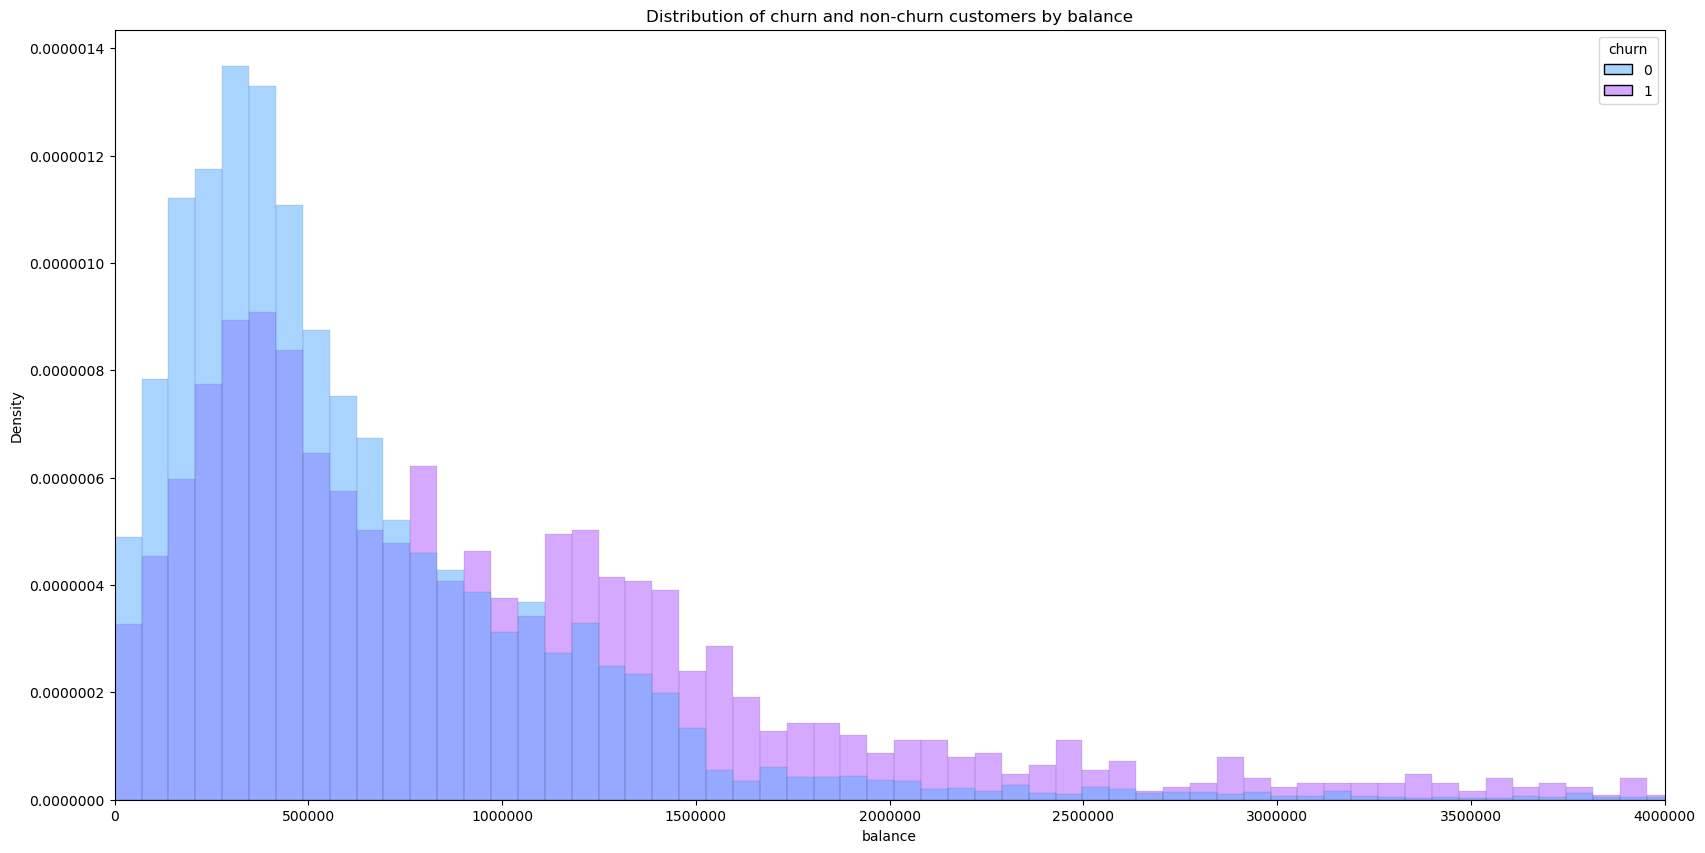

In [28]:
plt.figure(figsize=(20, 10))
ax=sns.histplot(data=bank, x='balance', hue='churn', stat='density', common_norm=False, palette='cool')
plt.title(f'Distribution of churn and non-churn customers by balance')
plt.ticklabel_format(style='plain')
plt.xlim(0, 4000000)
plt.show()

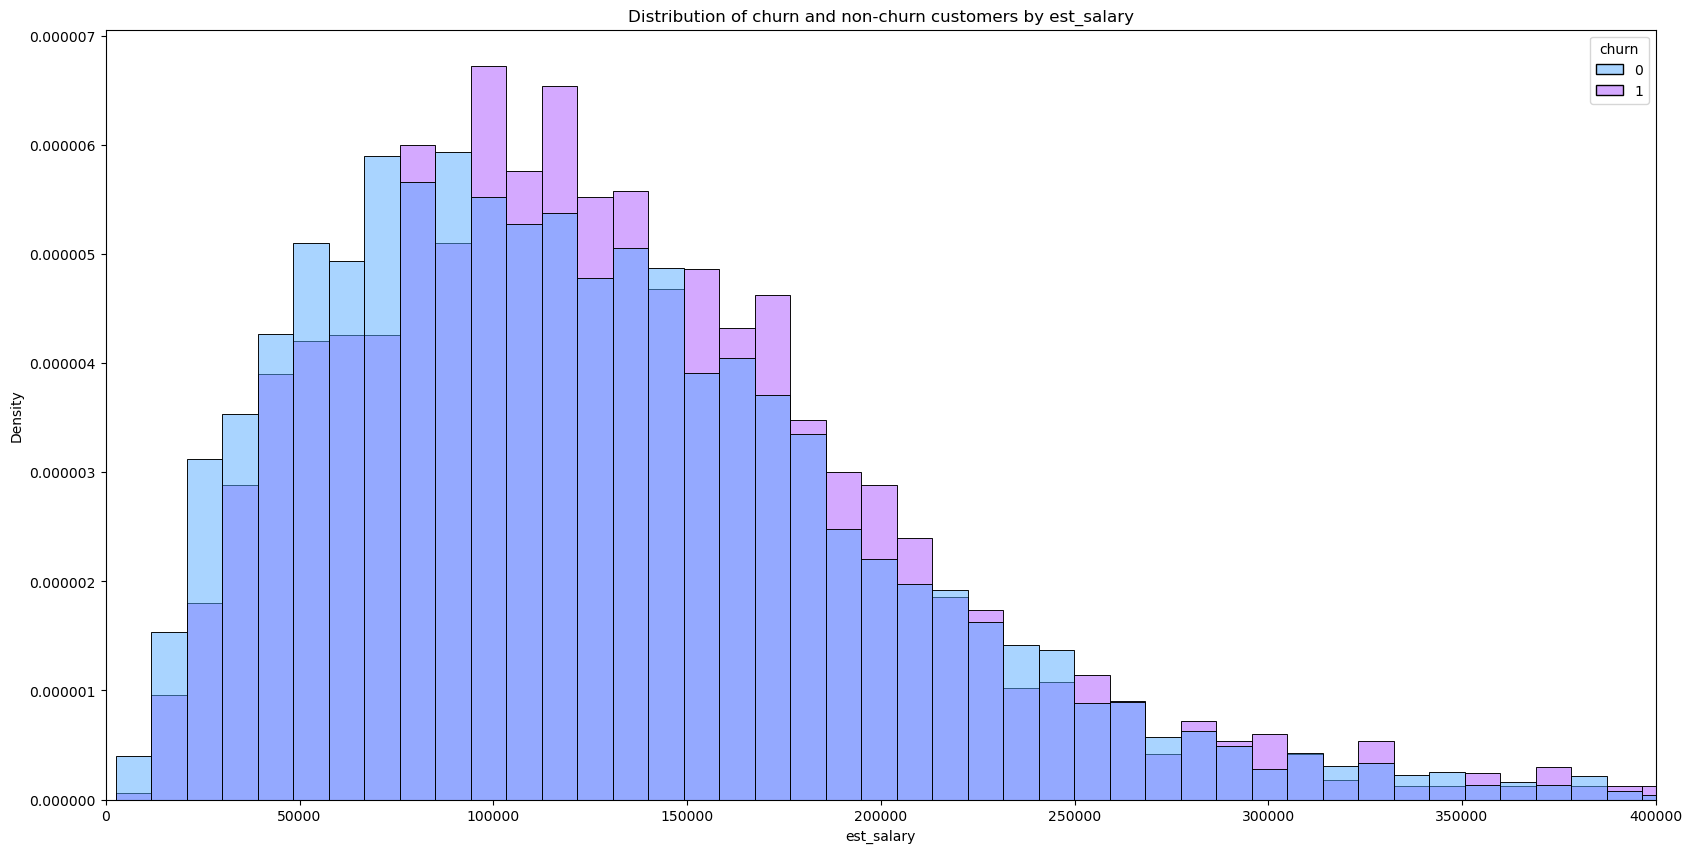

In [29]:
plt.figure(figsize=(20, 10))
ax=sns.histplot(data=bank, x='est_salary', hue='churn', stat='density', common_norm=False, palette='cool')
plt.title(f'Distribution of churn and non-churn customers by est_salary')
plt.ticklabel_format(style='plain')
plt.xlim(0, 400000)
plt.show()

**Summary:**  
Thanks to the distribution, we can notice:  
- a rather large dependence of the clients' outflow on the score criterion,   
- in terms of age, the dependence is not so strong, but we can distinguish the outflow at the age of 25-35 and 50-60 years old,  
- by balance criterion, clients with average balance leave more,  
- est_salary criterion is not significant.

**Using the Phik library, let's see the correlation of churn customers by categorical attributes:**

Let's set only appropriate columns for correlation:

In [30]:
phik_overview = bank.drop(columns=['index_id','user_id']).phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'est_salary', 'churn']


,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
score,1.00,0.09,0.07,0.04,0.53,0.17,0.42,0.21,0.05,0.40,0.23
city,0.09,1.00,0.01,0.09,0.06,0.04,0.12,0.07,0.03,0.17,0.02
gender,0.07,0.01,1.00,0.29,0.06,0.05,0.07,0.20,0.01,0.14,0.22
age,0.04,0.09,0.29,1.00,0.04,0.02,0.14,0.16,0.09,0.36,0.18
equity,0.53,0.06,0.06,0.04,1.00,0.00,0.58,0.22,0.05,0.29,0.35
balance,0.17,0.04,0.05,0.02,0.00,1.00,0.00,0.00,0.00,0.37,0.02
products,0.42,0.12,0.07,0.14,0.58,0.00,1.00,0.27,0.11,0.22,0.26
credit_card,0.21,0.07,0.20,0.16,0.22,0.00,0.27,1.00,0.05,0.04,0.20
last_activity,0.05,0.03,0.01,0.09,0.05,0.00,0.11,0.05,1.00,0.05,0.26
est_salary,0.40,0.17,0.14,0.36,0.29,0.37,0.22,0.04,0.05,1.00,0.05


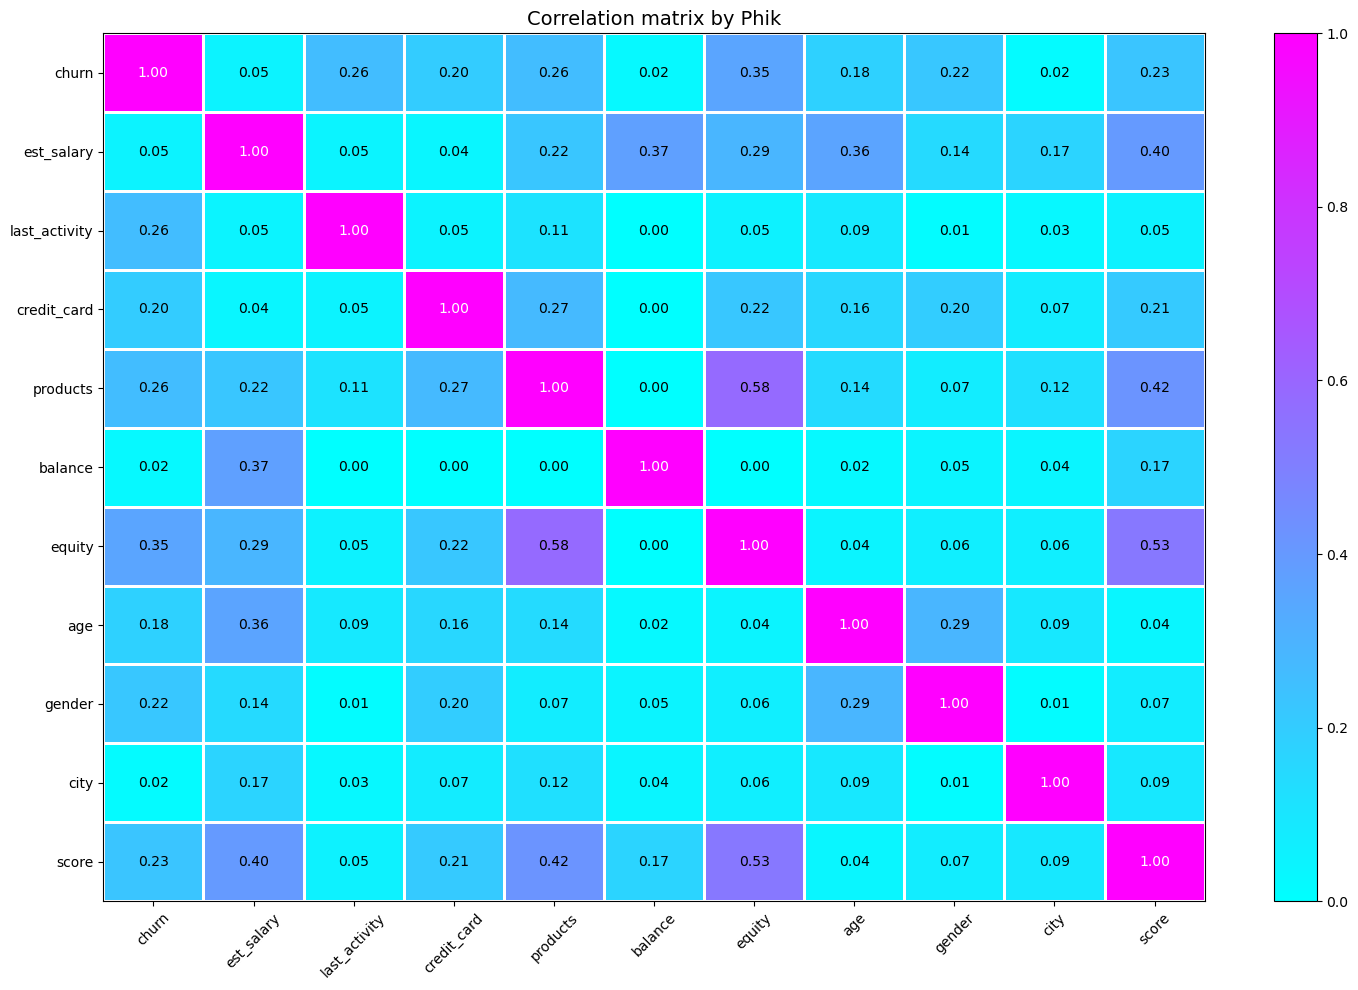

In [31]:
# plotting heatmap
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='cool', 
                        title = 'Correlation matrix by Phik', 
                        figsize=(15, 10))
plt.xticks(rotation = 45)
plt.tight_layout();

The dependence of customer churn on the following indicators (in descending order) is tracked:  
- equity (number of ownership points),
- products (bank products used),
- last_activity (user activity),  
- score (credit scoring points),
- gender,  
- credit_card,  
- age.

### Let's look at each indicator separately

In [32]:
# equity (number of ownership points)
churn_by_equity = bank.pivot_table(index='equity', values='churn', aggfunc=['sum', 'count'])
churn_by_equity.columns = churn_by_equity.columns.map(lambda index: f'{index[0]}_{index[1]}')
churn_by_equity['pct'] = round(churn_by_equity['sum_churn']/churn_by_equity['count_churn']*100, 1)
churn_by_equity.sort_values('pct', ascending=False)

,sum_churn,count_churn,pct
equity,,,
9,7,13,53.8
7,37,80,46.2
6,58,161,36.0
8,6,17,35.3
5,577,1918,30.1
4,464,1850,25.1
3,321,1542,20.8
2,166,1052,15.8
1,93,774,12.0


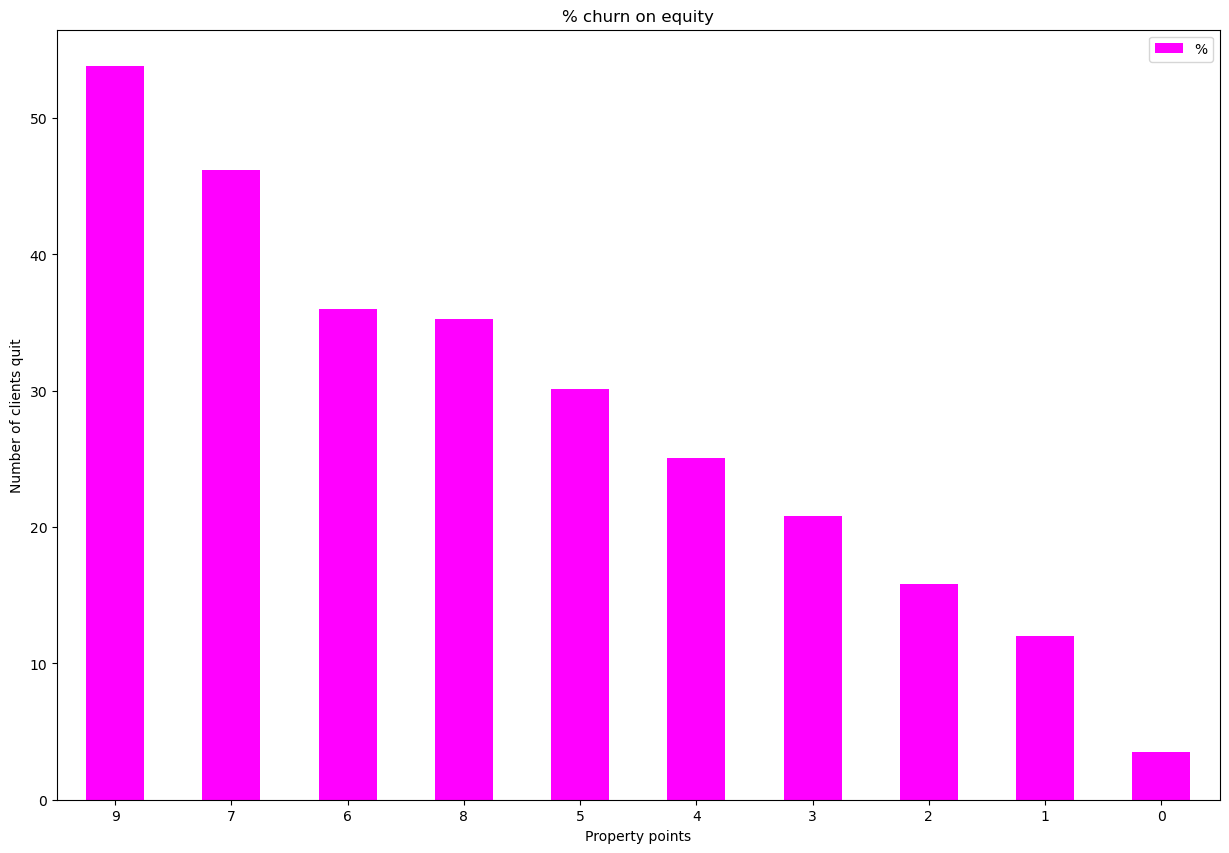

In [33]:
# plotting the churn visualisation depending on the number of property points
churn_by_equity['pct'].sort_values(ascending=False).plot(
        kind='bar', color='magenta', title='% churn on equity')
plt.xticks(rotation=0)
plt.xlabel('Property points')
plt.ylabel('Number of clients quit')

plt.legend('%');

The graph shows an almost direct correlation between the probability of client churn depending on the number of ownership points:  
- the number of churned customers with 9 ownership points 53.8% (overall, the share is small),  
- the largest share of users with 5 ownership points, churn rate 30.1%,  
- the least churn rate is given by clients with 0 ownership points, 3.5% (the share is relatively small)

In [34]:
# products (bank products used)
churn_by_product = bank.pivot_table(index='products', values='churn', aggfunc=['sum', 'count'])
churn_by_product.columns = churn_by_product.columns.map(lambda index: f'{index[0]}_{index[1]}')
churn_by_product['pct'] = round(churn_by_product['sum_churn']/churn_by_product['count_churn']*100, 1)
churn_by_product.sort_values('pct', ascending=False)

,sum_churn,count_churn,pct
products,,,
4,300,474,63.3
5,8,19,42.1
3,297,1039,28.6
2,979,5126,19.1
1,235,3341,7.0


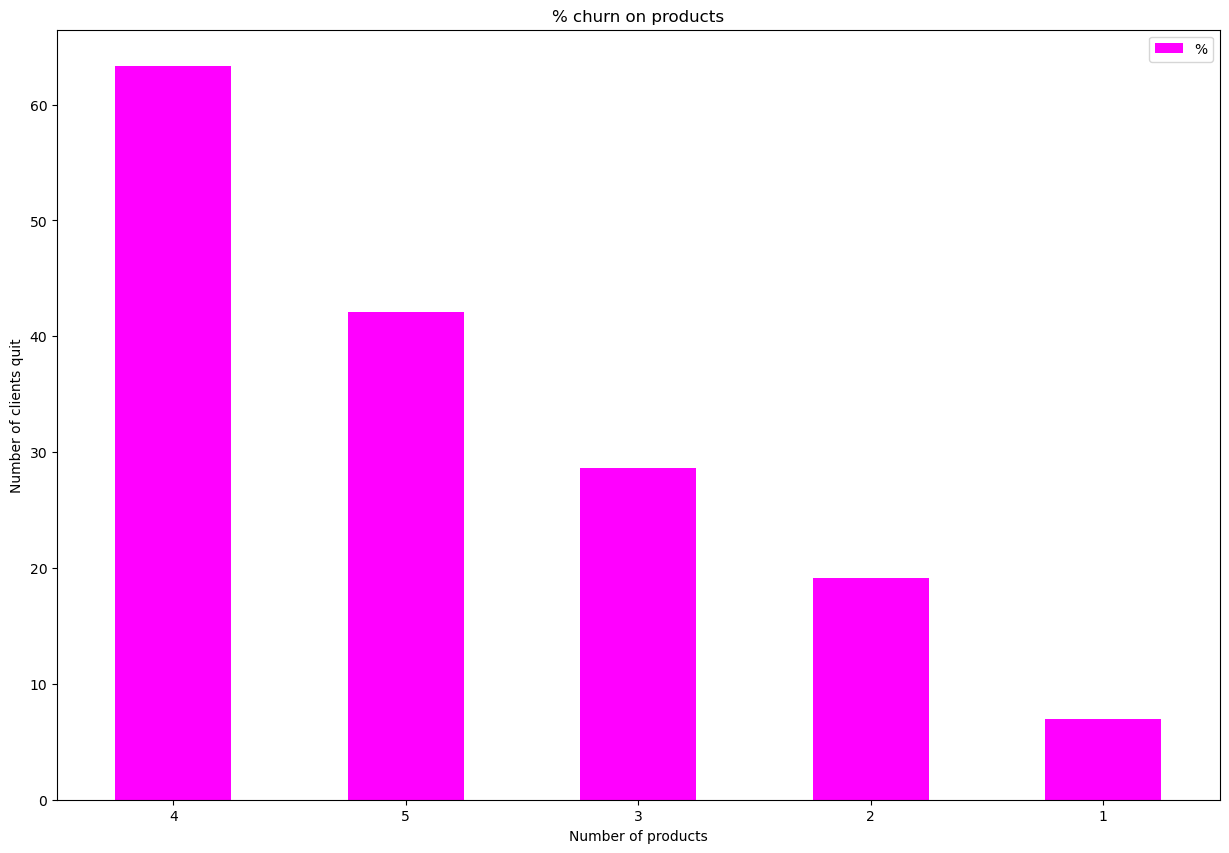

In [35]:
# # plotting the churn visualisation depending on the number of products used
churn_by_product['pct'].sort_values(ascending=False).plot(
        kind='bar', color='magenta', title='% churn on products')
plt.xticks(rotation=0)
plt.xlabel('Number of products')
plt.ylabel('Number of clients quit')

plt.legend('%');

The graph shows the probability of customer churn depending on the number of opened products in the bank:  
- the highest percentage of customers leave if they have 4 products (63.3%),  
- followed by users with 5 products, 42.1% (but their share is the lowest),  
- users with 3 opened products leave in 28.6% of cases,  
- the share of those who left with 2 products is 19.1%,  
- with one product - only 7.0%.

In [36]:
# last activity
churn_by_activity = bank.pivot_table(index='last_activity', values='churn', aggfunc=['sum', 'count'])
churn_by_activity.columns = churn_by_activity.columns.map(lambda index: f'{index[0]}_{index[1]}')
churn_by_activity['pct'] = round(churn_by_activity['sum_churn']/churn_by_activity['count_churn']*100, 1)

churn_by_activity = churn_by_activity.reset_index()
churn_by_activity['last_activity'] = churn_by_activity['last_activity'].replace(0, 'not active')
churn_by_activity['last_activity'] = churn_by_activity['last_activity'].replace(1, 'active')
churn_by_activity = churn_by_activity.set_index('last_activity')
churn_by_activity.sort_values('pct', ascending=False)

,sum_churn,count_churn,pct
last_activity,,,
active,1278,5235,24.4
not active,541,4764,11.4


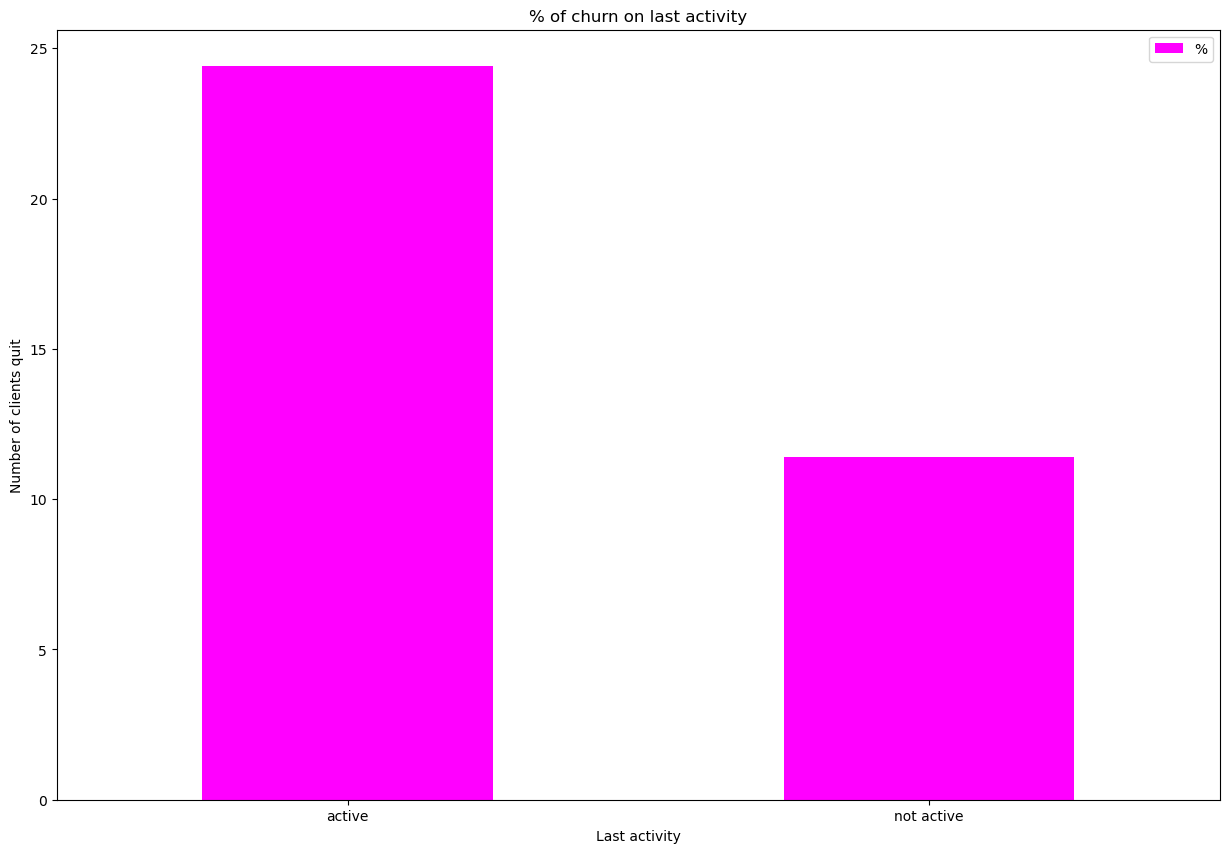

In [37]:
# churn by last activity visualization
churn_by_activity['pct'].sort_values(ascending=False).plot(
        kind='bar', color='magenta', title='% of churn on last activity')
plt.xticks(rotation=0)
plt.xlabel('Last activity')
plt.ylabel('Number of clients quit')

plt.legend('%');

In [38]:
# credit scoring points
churn_by_score = bank.pivot_table(index='score', values='churn', aggfunc=['sum', 'count'])
churn_by_score.columns = churn_by_score.columns.map(lambda index: f'{index[0]}_{index[1]}')
churn_by_score['pct'] = round(churn_by_score['sum_churn']/churn_by_score['count_churn']*100, 1)
churn_score_zero = churn_by_score.query('pct == 0')
churn_by_score_30 = churn_by_score.query('pct >= 30')
display(churn_score_zero.sort_values('score', ascending=False))
display(churn_by_score_30.sort_values(['pct','score'], ascending=False))

,sum_churn,count_churn,pct
score,,,
998.0,0,1,0.0
997.0,0,2,0.0
996.0,0,2,0.0
995.0,0,1,0.0
994.0,0,2,0.0
...,...,...,...
650.0,0,2,0.0
649.0,0,7,0.0
648.0,0,2,0.0


,sum_churn,count_churn,pct
score,,,
987.0,2,3,66.7
999.0,1,2,50.0
866.0,24,50,48.0
868.0,21,47,44.7
993.0,3,7,42.9
877.0,17,40,42.5
870.0,18,45,40.0
862.0,20,53,37.7
869.0,19,54,35.2


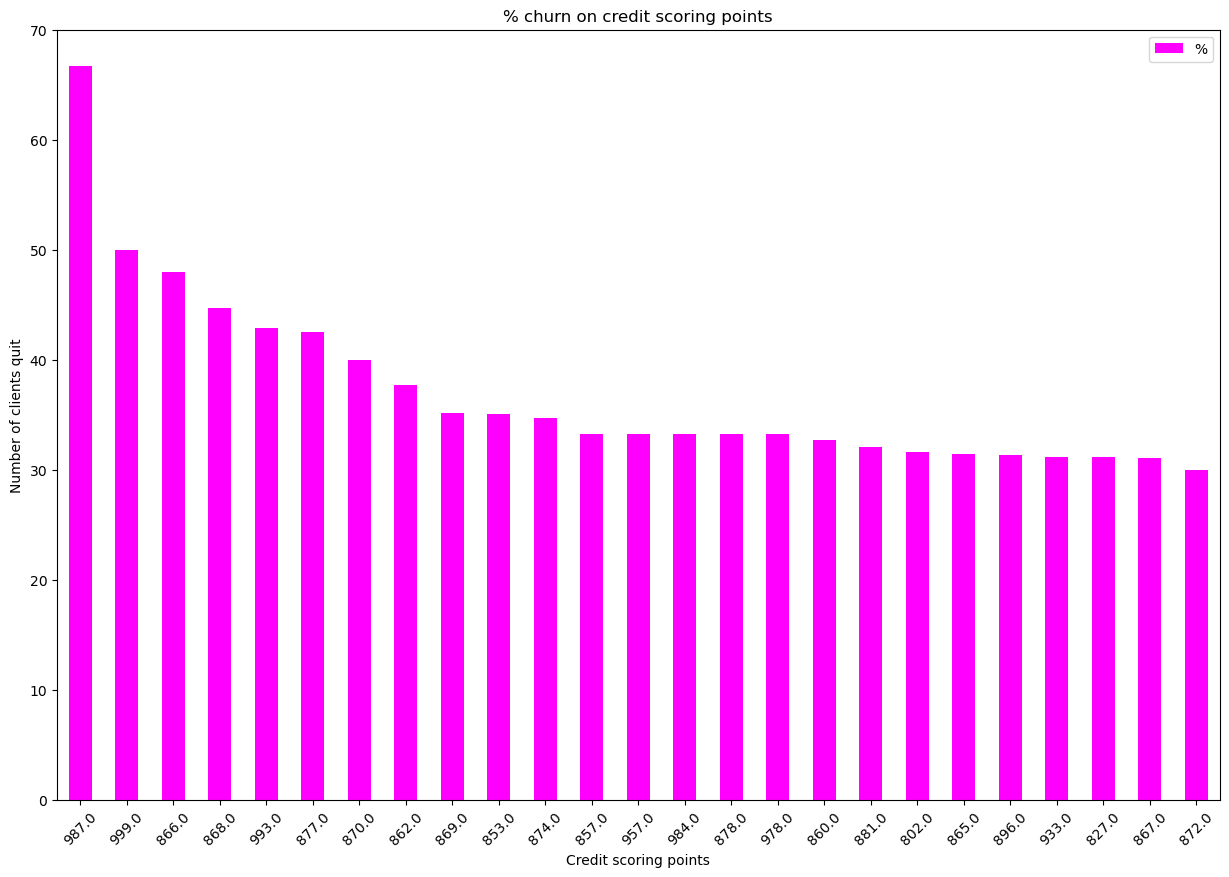

In [39]:
# churn on credit scoring points visualozation
churn_by_score_30['pct'].sort_values(ascending=False).plot(
        kind='bar', color='magenta', title='% churn on credit scoring points')
plt.xticks(rotation=45)
plt.xlabel('Credit scoring points')
plt.ylabel('Number of clients quit')
#plt.xlim(100, 400)
plt.legend('%');

There is a roughly direct relationship between the quit rate and the scoring points. Clients with a high score are more likely to leave. We should not forget that there are clients with high scores who do not leave.   
We also see that users with scoring below 642 do not leave the bank at all.
This is probably due to the fact that the better the client's credit history, the more likely it is that he will, for example, repay the loan and leave. And users with a poor credit score take longer to repay.

In [40]:
# churn on gender
churn_by_gender = bank.pivot_table(index='gender', values='churn', aggfunc=['sum', 'count'])
churn_by_gender.columns = churn_by_gender.columns.map(lambda index: f'{index[0]}_{index[1]}')
churn_by_gender['pct'] = round(churn_by_gender['sum_churn']/churn_by_gender['count_churn']*100, 1)
churn_by_gender = churn_by_gender.reset_index()

churn_by_gender['gender'] = churn_by_gender['gender'].replace('М', 'M')
churn_by_gender['gender'] = churn_by_gender['gender'].replace('Ж', 'F')
churn_by_gender = churn_by_gender.set_index('gender')

churn_by_gender.sort_values('pct', ascending=False)

,sum_churn,count_churn,pct
gender,,,
M,1183,5005,23.6
F,636,4994,12.7


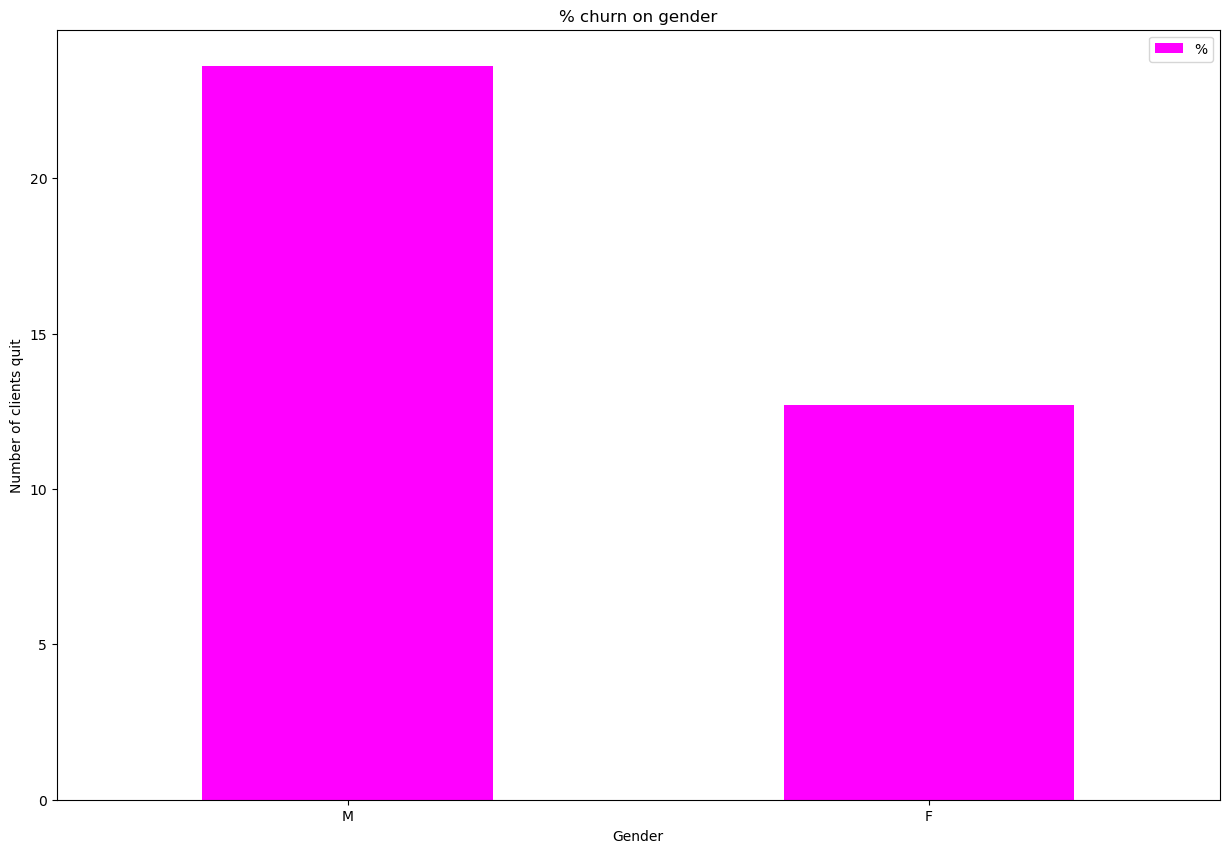

In [41]:
# churn on gender visualization
churn_by_gender['pct'].sort_values(ascending=False).plot(
        kind='bar', color='magenta', title='% churn on gender')
plt.xticks(rotation=0)
plt.xlabel('Gender')
plt.ylabel('Number of clients quit')

plt.legend('%');

In [42]:
# churn on credit card
churn_by_card = bank.pivot_table(index='credit_card', values='churn', aggfunc=['sum', 'count'])
churn_by_card.columns = churn_by_card.columns.map(lambda index: f'{index[0]}_{index[1]}')
churn_by_card['pct'] = round(churn_by_card['sum_churn']/churn_by_card['count_churn']*100, 1)

churn_by_card = churn_by_card.reset_index()
churn_by_card['credit_card'] = churn_by_card['credit_card'].replace(0, 'no card')
churn_by_card['credit_card'] = churn_by_card['credit_card'].replace(1, 'with card')
churn_by_card = churn_by_card.set_index('credit_card')
churn_by_card.sort_values('pct', ascending=False)

,sum_churn,count_churn,pct
credit_card,,,
no card,816,3195,25.5
with card,1003,6804,14.7


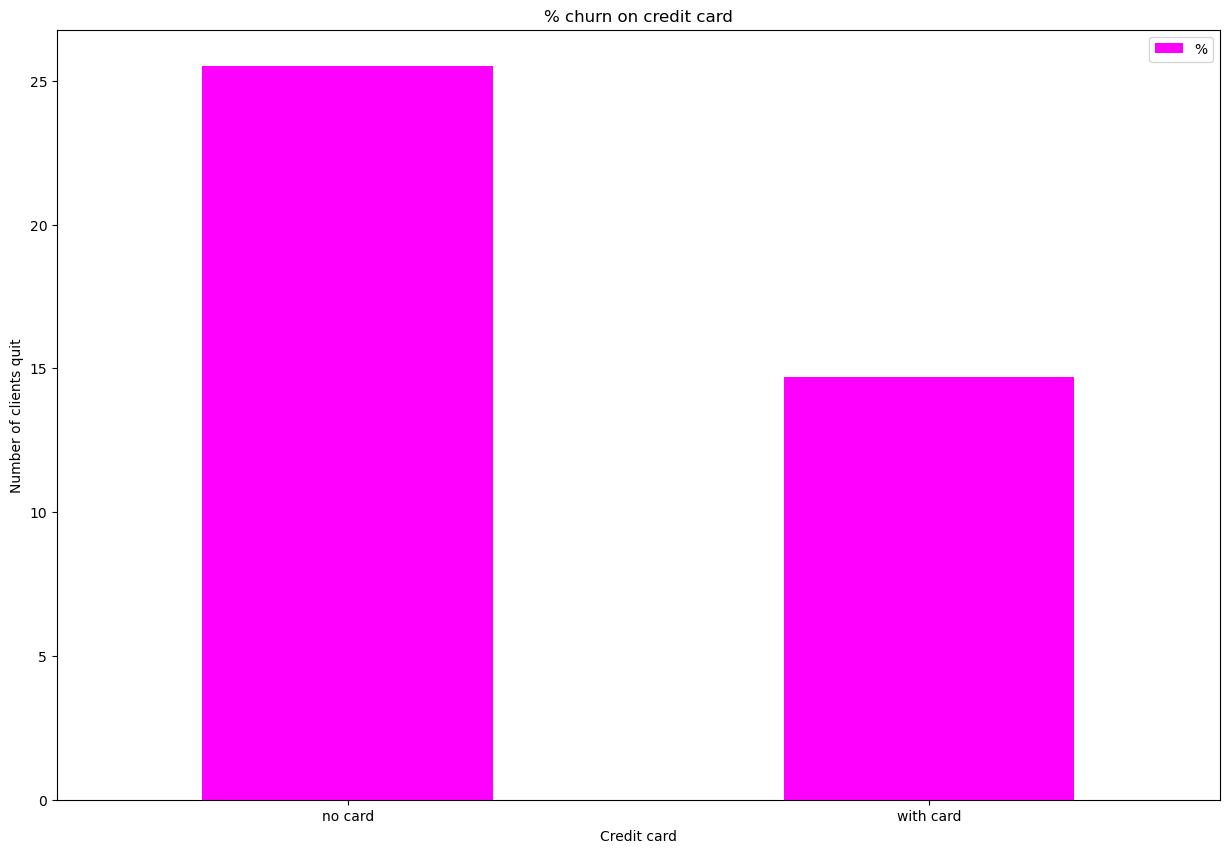

In [43]:
# churn on credit card visualization
churn_by_card['pct'].sort_values(ascending=False).plot(
        kind='bar', color='magenta', title='% churn on credit card')
plt.xticks(rotation=0)
plt.xlabel('Credit card')
plt.ylabel('Number of clients quit')

plt.legend('%');

In [44]:
# churn on age
churn_by_age = bank.pivot_table(index='age', values='churn', aggfunc=['sum', 'count'])
churn_by_age.columns = churn_by_age.columns.map(lambda index: f'{index[0]}_{index[1]}')
churn_by_age['pct'] = round(churn_by_age['sum_churn']/churn_by_age['count_churn']*100, 1)
display(churn_by_age.sort_values('pct', ascending=False))
round(churn_by_age.reset_index()['age'].mean(), 1)

,sum_churn,count_churn,pct
age,,,
54.0,47,139,33.8
52.0,50,154,32.5
56.0,47,149,31.5
27.0,53,171,31.0
58.0,51,169,30.2
...,...,...,...
77.0,0,8,0.0
76.0,0,13,0.0
71.0,0,36,0.0


51.5

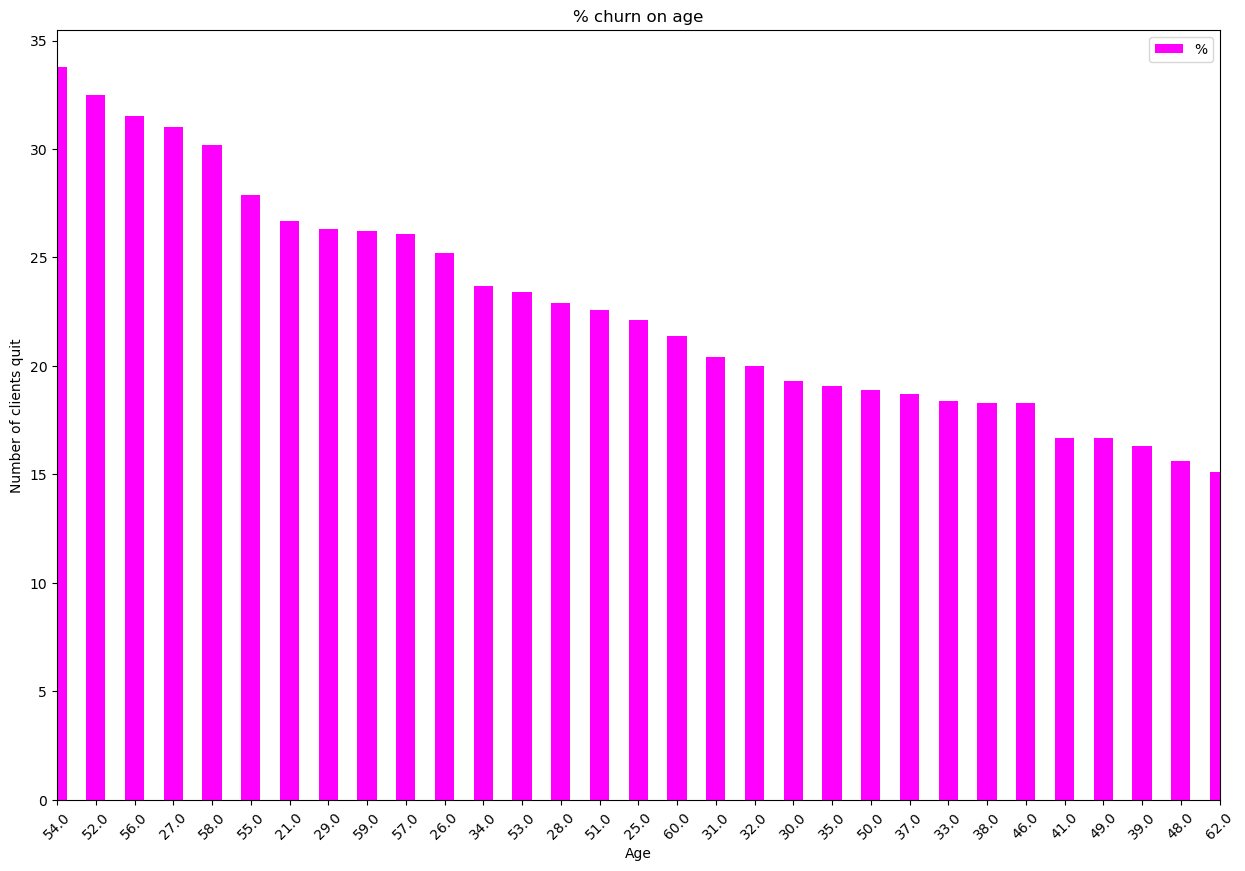

In [45]:
# churn on age visualization
churn_by_age['pct'].sort_values(ascending=False).plot(
        kind='bar', color='magenta', title='% churn on age')
plt.xticks(rotation=45)
plt.xlabel('Age')
plt.ylabel('Number of clients quit')
plt.xlim(0, 30)
plt.legend('%');

Based on the obtained data, let's draw up portraits of outgoing customers.  
The most stand-out parameters are:  
- By number of products:  
    more than 3
- by property score:  
    more than 5
- by activity:  
    active
- by gender:  
    М
- by credit card:    
    no card
- by credit scoring:  
    over 641 points
- age group:  
    40 years of age or older

### Let's combine different categories of customers who have left to create portraits of classic churned customers:

For better illustrative purposes, let's find portraits of customers who quit, making up groups of 500-2000 clients

In [46]:
# a slice of customers in a segment
portrait_1 = bank.query('gender == "М" and score >= 642 and equity >= 5')
# number of clients in a segment
cnt_portrait_1 = portrait_1['index_id'].count()

# portrait 1
churn_portrait_1 = bank.query('gender == "М" and score >= 642 and equity >= 5 and churn == 1')
# number of clients quit in a segment
cnt_churn_portrait_1 = churn_portrait_1['index_id'].count()

display(churn_portrait_1)
print('Portrait 1: male, credir scoring >= 642, equity >= 5')
print('Total number of clients in segment 1: ' + str(cnt_portrait_1))
print('Total number of clients quit in segment 1: ' + str(cnt_churn_portrait_1))
print('Churn clients share: ' + str(round(cnt_churn_portrait_1 / cnt_portrait_1 * 100, 1)) + '%')

,index_id,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
4,4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1
58,58,164676,860.0,Ярославль,М,37.0,5,648594.03,2,1,1,213586.86,1
72,72,156677,873.0,Ярославль,М,39.0,5,915959.85,3,0,1,154034.62,1
73,73,155403,859.0,Рыбинск,М,56.0,5,652553.80,2,1,1,60791.77,1
77,77,191976,937.0,Ярославль,М,33.0,5,2061152.96,2,1,1,280670.62,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9908,9908,211089,993.0,Рыбинск,М,38.0,6,4542980.70,1,1,1,491609.13,1
9909,9909,171011,885.0,Ярославль,М,35.0,5,1133520.90,2,0,0,175463.34,1
9933,9933,197891,899.0,Ярославль,М,37.0,5,1422472.42,2,0,1,231978.68,1
9981,9981,154871,892.0,Рыбинск,М,39.0,5,636287.72,2,0,1,227288.27,1


Portrait 1: male, credir scoring >= 642, equity >= 5
Total number of clients in segment 1: 1123
Total number of clients quit in segment 1: 464
Churn clients share: 41.3%


**Another way to calculate the above:**

In [47]:
# a slice of customers in a segment
portrait_1 = bank.query('gender == "М" and score >= 642 and equity >= 5')
# number of clients in a segment
cnt_portrait_1 = portrait_1['index_id'].count()

# portrait 1
churn_portrait_1 = bank.query('gender == "М" and score >= 642 and equity >= 5 and churn == 1')
# number of clients quit in a segment
cnt_churn_portrait_1 = portrait_1['churn'].sum()

#display(churn_portrait_1)
print('Portrait 1: male, credir scoring >= 642, equity >= 5')
print('Total number of clients in segment 1: ' + str(cnt_portrait_1))
print('Total number of clients quit in segment 1: ' + str(cnt_churn_portrait_1))
print('Churn clients share: ' + str(round(portrait_1['churn'].mean() * 100, 1)) + '%')

Portrait 1: male, credir scoring >= 642, equity >= 5
Total number of clients in segment 1: 1123
Total number of clients quit in segment 1: 464
Churn clients share: 41.3%


In [48]:
# a slice of customers in a segment
portrait_2 = bank.query('gender == "М" and score >= 642 and products >= 3')
# number of clients in a segment
cnt_portrait_2 = portrait_2['index_id'].count()

# portrait 2
churn_portrait_2 = bank.query('gender == "М" and score >= 642 and products >= 3 and churn == 1')
# number of clients quit in a segment
cnt_churn_portrait_2 = churn_portrait_2['index_id'].count()

#churn_portrait_1 = bank.query('products >= 3 and equity >= 5 and last_activity == 1 and gender == "М" and score >= 642 and age_group == "46-62" and churn == 1')
display(churn_portrait_2)
print('Portrait 2: male, credit scoring >= 642, products >= 3')
print('Total number of clients in segment 2: ' + str(cnt_portrait_2))
print('Total number of clients quit in segment 2: ' + str(cnt_churn_portrait_2))
print('Churn clients share: ' + str(round(cnt_churn_portrait_2 / cnt_portrait_2 * 100, 1)) + '%')

,index_id,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
72,72,156677,873.0,Ярославль,М,39.0,5,915959.85,3,0,1,154034.62,1
81,81,223978,850.0,Рыбинск,М,34.0,5,351583.16,4,0,1,115354.97,1
160,160,171716,908.0,Рыбинск,М,30.0,3,245237.57,4,1,1,78324.89,1
177,177,147950,899.0,Ярославль,М,37.0,4,2229215.25,3,0,1,304260.47,1
208,208,214357,819.0,Ярославль,М,34.0,3,1228101.55,4,1,1,141504.44,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9872,9872,227649,865.0,Ярославль,М,51.0,6,904732.82,4,1,0,216582.58,1
9876,9876,190603,822.0,Ярославль,М,35.0,3,310135.19,3,0,1,79289.04,1
9896,9896,133758,919.0,Ярославль,М,42.0,5,2183175.39,4,1,1,206343.23,1
9941,9941,223285,862.0,Ростов,М,46.0,3,1784723.84,4,1,1,202524.28,1


Portrait 2: male, credit scoring >= 642, products >= 3
Total number of clients in segment 2: 752
Total number of clients quit in segment 2: 376
Churn clients share: 50.0%


In [49]:
# a slice of customers in a segment
portrait_3 = bank.query('products >= 3 and age>=40')
# number of clients in a segment
cnt_portrait_3 = portrait_3['index_id'].count()

# portrait 3
churn_portrait_3 = bank.query('products >= 3 and age >= 40 and churn == 1')
# number of clients quit in a segment
cnt_churn_portrait_3 = churn_portrait_3['index_id'].count()

display(churn_portrait_3)
print('Portrait 3: products >= 3, age >= 40')
print('Total number of clients in segment 3: ' + str(cnt_portrait_3))
print('Total number of clients quit in segment 3: ' + str(cnt_churn_portrait_3))
print('Churn clients share: ' + str(round(cnt_churn_portrait_3 / cnt_portrait_3 * 100, 1)) + '%')

,index_id,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
83,83,189395,792.0,Ярославль,Ж,66.0,1,266586.19,3,0,1,51536.94,1
148,148,122769,868.0,Ростов,Ж,58.0,5,1334745.59,4,0,1,63049.60,1
237,237,187043,827.0,Ярославль,М,69.0,5,1024786.60,3,0,0,85853.26,1
283,283,136262,878.0,Ярославль,Ж,44.0,3,1151318.03,4,1,1,222976.85,1
314,314,220193,987.0,Рыбинск,М,58.0,5,1137747.96,3,0,0,52950.12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9861,9861,179288,908.0,Ярославль,Ж,55.0,5,2036988.28,4,1,1,122581.49,1
9872,9872,227649,865.0,Ярославль,М,51.0,6,904732.82,4,1,0,216582.58,1
9896,9896,133758,919.0,Ярославль,М,42.0,5,2183175.39,4,1,1,206343.23,1
9941,9941,223285,862.0,Ростов,М,46.0,3,1784723.84,4,1,1,202524.28,1


Portrait 3: products >= 3, age >= 40
Total number of clients in segment 3: 820
Total number of clients quit in segment 3: 306
Churn clients share: 37.3%


In [50]:
# a slice of customers in a segment
portrait_4 = bank.query('credit_card == 0 and last_activity == 1')
# number of clients in a segment
cnt_portrait_4 = portrait_4['index_id'].count()

# portrait 4
churn_portrait_4 = bank.query('credit_card == 0 and last_activity == 1 and churn == 1')
# number of clients quit in a segment
cnt_churn_portrait_4 = churn_portrait_4['index_id'].count()

display(churn_portrait_4)
print('Portrait 4: no credit card, active')
print('Total number of clients in segment 4: ' + str(cnt_portrait_4))
print('Total number of clients churn in segment 4: ' + str(cnt_churn_portrait_4))
print('Churn clients share: ' + str(round(cnt_churn_portrait_4 / cnt_portrait_4 * 100, 1)) + '%')

,index_id,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
3,3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
61,61,136096,896.0,Ярославль,Ж,39.0,5,657597.09,2,0,1,266033.98,1
72,72,156677,873.0,Ярославль,М,39.0,5,915959.85,3,0,1,154034.62,1
81,81,223978,850.0,Рыбинск,М,34.0,5,351583.16,4,0,1,115354.97,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9891,9891,161917,963.0,Ярославль,М,27.0,4,4028889.42,2,0,1,376158.61,1
9912,9912,149773,900.0,Ростов,Ж,34.0,2,410240.77,2,0,1,171986.36,1
9933,9933,197891,899.0,Ярославль,М,37.0,5,1422472.42,2,0,1,231978.68,1
9981,9981,154871,892.0,Рыбинск,М,39.0,5,636287.72,2,0,1,227288.27,1


Portrait 4: no credit card, active
Total number of clients in segment 4: 1751
Total number of clients churn in segment 4: 613
Churn clients share: 35.0%


## Statistical hypotheses statement and testing

### Let's test the hypothesis of a difference in income between those customers who
who left and those who stayed.

Let's introduce the null hypothesis and the alternative hypothesis:

$\begin{equation*}
 \begin{cases}
   H_0 :\text{The average revenues of the remaining and quitting customers are equal,}\\
   H_1 :\text{The average revenues of remaining and quitting customers are different}.
 \end{cases}
\end{equation*}$

Let's test the hypothesis using t-test:

In [51]:
alpha = 0.05 # critical level of statistical significance

sample_salary_0 = bank[bank['churn']==0]['est_salary']
sample_salary_1 = bank[bank['churn']==1]['est_salary']

results = st.ttest_ind(sample_salary_0, sample_salary_1)

print('p-value for the comparison of the groups of remaining and quitting customers: ', results.pvalue)

if results.pvalue < alpha:
    print('Reject the null hypothesis.')
else:
    print(
        'Failed to reject the null hypothesis.'
    )

p-value for the comparison of the groups of remaining and quitting customers:  0.8839364433181659
Failed to reject the null hypothesis.


**Summary:**  
Hypothesis testing did not reveal the dependence of customer churn on income.  
Thanks to statistical research we also did not reveal any dependence.

### Let's test one more hypothesis about the data presented, which will help to clarify the study

Let's test the dependence of churn on the number of property scores.
Let's state the null and alternative hypotheses:

$\begin{equation*}
 \begin{cases}
   H_0 :\text{The average number of ownership points of the remaining and leaving customers is equal,}\\
   H_1 :\text{The average number of ownership points of the remaining and leaving customers is different.}
 \end{cases}
\end{equation*}$

Let's test the hypothesis using t-test:

In [52]:
alpha = 0.05 # critical level of statistical significance

sample_equity_0 = bank[bank['churn']==0]['equity']
sample_equity_1 = bank[bank['churn']==1]['equity']

results = st.ttest_ind(sample_equity_0, sample_equity_1)

print('p-value for the comparison of the groups of remaining and quitting customers: ', results.pvalue)

if results.pvalue < alpha:
    print('Reject the null hypothesis.')
else:
    print(
        'Failed to reject the null hypothesis.'
    )


p-value for the comparison of the groups of remaining and quitting customers:  2.6060183523439987e-167
Reject the null hypothesis.


**Summary:**  
With the help of t-test we have concluded that the number of property scores has an effect on churn. This was also observed in the exploratory analysis.

## General summary:  
The exploratory analysis identified the main parameters of users who leave:  
- By number of products:  
    3 or more
- by ownership score:  
    from 5
- by activity:  
    active
- by gender:  
    М
- by credit card availability:    
    none
- by credit scoring:  
    642 points and above
- age group:  
    40 and over  
  
By combining different attributes, we have found groups of 500-2000 customers that share common features.   
This provides us with additional data, which we can use to avoid customer churn by monitoring and adjusting:  
- men with credit scores of 642 and above,  
- men with credit scores of 5 and above,  
- users aged 40 and over with a credit score of 642,  
- active customers who do not have a credit card.

**Assumption:**  
We can see that, in general, all groups of departing users are connected with credit in one form or another:    
- high scoring, indicating good creditworthiness: a male has repaid a loan quickly and on time, and no more credit is needed -- new loans with a more favourable rate can be offered to such men,  
- men with high property scores are also more reliable and faster in repaying their obligations, possibly going to another bank with more favourable terms,  
- all users with high credit scoring are faster than others to lose the need to remain a customer of a bank if there are more favourable terms at another,  
- customers who have no credit cards (i.e. no obligations to the bank) tend to change banks more quickly if there are more favourable terms at competitors.  

**Necessary:**  
Ask potential quitting customers (from the groups found) what would be interesting, favourable for them, what makes them uncomfortable, why they might leave and other questions.

Presentation:  
https://drive.google.com/file/d/1FECwnV2pIRI2R4uq80nBkky8Mio77V2u/view?usp=sharing